In [1]:
import sys, os
import pathlib
import time
import importlib

import numpy as np
from scipy.linalg import null_space
# import sympy
import matplotlib.pyplot as plt

import cv2

In [10]:
sys.path

['/Users/noshita/working_dir/curve_sketch/simlation_data',
 '/Users/noshita/.pyenv/versions/3.9.9/lib/python39.zip',
 '/Users/noshita/.pyenv/versions/3.9.9/lib/python3.9',
 '/Users/noshita/.pyenv/versions/3.9.9/lib/python3.9/lib-dynload',
 '',
 '/Users/noshita/Library/Caches/pypoetry/virtualenvs/curve-sketch-CVtvuAS6-py3.9/lib/python3.9/site-packages',
 '/Users/noshita/working_dir/curve_sketch',
 '/Users/noshita/working_dir/curve_sketch/src']

In [52]:
%load_ext autoreload
%autoreload 2

if not os.path.abspath("../src") in sys.path:
    sys.path.append(os.path.abspath("../src"))

from src import normalization
from src import Camera
from src import camera_correspondence, FF_mat, epipole_angle, pair_and_key_gen, coll_dict_gen
from src import pt_pair, FR_frags, FR_check
from src import min_dist, tri, excluded_Parray, dot_P_frag, gen_support_dict
from src import all_D, frag_list_fraged

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 関数定義

### 保存

In [2]:
# 曲線分割
def split_list(contour_length, max_frag_len=100, min_frag_len=40, min_overrap=20):
    
    # 輪郭のフラグメントの位置を指定(最小40 pixl)
    if contour_length > max_frag_len:
        pass
    
    elif contour_length < min_frag_len:
        return None
    
    elif contour_length == min_frag_len:
        return [[0,min_frag_len-1]]
    
    else:
        max_frag_len = contour_length
    
    step0 = np.random.randint(min_frag_len, max_frag_len) # 一つ目のフラグメントの長さ（40から100）
    sep_list = [[0,step0]]
    back = np.random.randint(min_overrap, step0-1) # フラグメントを重ねるために戻す分を決める（最小10 pixl）
    next_start = step0 - back
    
    while True:
        
        # 戻った分(back)より進む
        if back+1 > min_frag_len:
            step = np.random.randint(back+1, max_frag_len)
        else:
            step = np.random.randint(min_frag_len, max_frag_len)

        full_length = next_start + step
        sept = [next_start, full_length]
        sep_list.append(sept)
        back = np.random.randint(min_overrap, step-1)
        next_start = full_length - back

        # 終了判定
        if full_length > contour_length:
            break
    
    # 超過した分戻す（長さはそのまま）
    difference = sep_list[-1][1] - (contour_length-1)
    sep_list[-1][0] -= difference
    sep_list[-1][1] -= difference
    
    return sep_list


def contours_split(contour):
    
    #contour.shape == (N, 2)
    contour_length = contour.shape[0]
    sp_list = split_list(contour_length)
    
    if sp_list == None:
        return None
    
    frag_list = []
    # 位置のリスト通りにスライス
    for sp in sp_list:
        #print(sp)
        frag_list.append(contour[sp[0]:sp[1],:])

    return frag_list


def all_fraged(contours_list):
    
    # 輪郭のリストからフラグメントのリストを得る
    frags_list = []

    #for i in contours_list:
    #temp_list = []
    frags = []
    for j in contours_list:
        temp_frags = contours_split(j.squeeze())
            
        if temp_frags != None:
            frags += temp_frags

    #if frags != []:
    #    frags_list.append(frags)
    
    return frags

def frag_list_fraged(frags_list):# frags_list[色][輪郭][sep][座標]
    img_frag_list = []
    for frag in frags_list:
        color_frag = all_fraged(frag)
        img_frag_list.append(color_frag)
    return img_frag_list

In [4]:
# epipole取得

def contour_disassembly(contour_list):
    con_dis = []
    for i in range(len(contour_list)):
        if contour_list[i] == []:
            continue
        which_dis = np.concatenate(contour_list[i])
        con_dis.append(which_dis)
        
    return np.concatenate(con_dis)

In [5]:
# エピポーラ関係

def para2line(parameter):
    
    # 一つのパラメータが渡された時を想定
    line_coode = np.zeros((1920,2), dtype=np.int64)
    para = np.squeeze(parameter)# 3次ベクトル
    for x in range(1920):
        y = int((-para[0]*x - para[2])/para[1])
        line_coode[x,0] = x
        line_coode[x,1] = y
    
    return line_coode


def epiline_cal(frag_paras):
    # 全ての色に対するエピポーラ線の帯の計算
    # lines[色][フラグメント][線][座標]
    lines = []
    for color in frag_paras:
        temp_color = []
        
        for frag in color:
            temp_line = []

            for point in frag:
                line = para2line(point)
                temp_line.append(line)

            temp_color.append(temp_line)
        lines.append(temp_color)
        
    return lines


def frags_vs_line(img2_frags, frag_epiline):
    
    # frag_epiline shape(1920, 2)
    surport = np.zeros(len(img2_frags))
    for i in frag_epiline:
        for j, frag in enumerate(img2_frags):
            if i in frag:
                surport[j] += 1
    
    return surport


def pair_frag_idx(img2_frags, frag_epilines):
    surport = np.zeros(len(img2_frags))
    for epi in frag_epilines:
        surport += frags_vs_line(img2_frags, epi)
        
    return surport, np.argmax(surport)


pt1 = [1920-741,758] # 0
pt2 = [1920-858,834] # 2
F = cam_pairs_F[(0,2)] #0to2
pt2, pt1 = min_dist(F, pt2, pt1)
print(pt1,pt2)

pt1 = np.array([pt1[0],pt1[1],1]) # 0
pt2 = np.array([pt2[0],pt2[1],1]) # 2

np.dot(np.dot(pt2, F),pt1)

tri(cam_list[0].P, cam_list[2].P, pt1, pt2)

## カメラ

In [12]:
cam_list = [Camera(i) for i in range(48)]
for i in range(len(cam_list)):
    cam_list[i].img_load()
    cam_list[i].contour_extraction()
    cam_list[i].para_load()
#cam_pairs = camera_correspondence(cam_list)

In [15]:
# エピポール取得
cam_pairs = camera_correspondence(cam_list)

epipole_dict = {i:[] for i in range(len(cam_list))}
cam_pairs_F = {}
for i in cam_pairs:
    epipole1, epipole2, F = FF_mat(cam_list[i[0]].A, cam_list[i[1]].A, cam_list[i[0]].Rt, cam_list[i[1]].Rt)
    epipole_dict[i[0]].append(normalization(epipole1))
    epipole_dict[i[1]].append(normalization(epipole2))
    cam_pairs_F[i] = F

In [17]:


def expand(idx_l, list_length):
    del_list = []
    for i in idx_l:
        if np.isnan(i):
            continue
        if i-2 < 0:
            del_list.append(list_length + i-2)
        else:
            del_list.append(i-2)
        
        if i-1 < 0:
            del_list.append(list_length + i-1)
        else:
            del_list.append(i-1)
        
        del_list.append(i)
        
        if i+1 > list_length-1:
            del_list.append(i+1-list_length)
        else:
            del_list.append(i+1)
        if i+2 > list_length-1:
            del_list.append(i+2-list_length)
        else:
            del_list.append(i+2)
    return sorted(list(set(del_list)))

def differential(angles):
    # エピポーラ線に平行な接線をもつ点(前後方微分の正負を比べたほうが良い)
    del_idx = []
    for i in range(len(angles)):
        if np.isnan(angles[i]):
            continue
        if i == len(angles)-1:
            if np.sign(angles[i]-angles[i-1]) != np.sign(angles[0]-angles[i]): #or abs(angles[0]-angles[i-1])/2 < 0.001:
                del_idx.append(i)
        else:
            if np.sign(angles[i]-angles[i-1]) != np.sign(angles[i+1]-angles[i]):# or abs(angles[i+1]-angles[i-1])/2 < 0.001:
                del_idx.append(i)
    #del_idx = expand(del_idx, len(angles))
    
    return del_idx

def marge_del(epi_del_list):
    im_del_list = []
    for i, col in enumerate(epi_del_list[0]):
        color_list = []
        for j, con in enumerate(col):
            color_list.append(list(set(epi_del_list[0][i][j] + epi_del_list[1][i][j])))
        im_del_list.append(color_list)
    return im_del_list

def all_D(angles_list):
    # 画像1枚に対して削除リストを作成
    all_del_list = []
    for epi in angles_list:
        epi_del_list = []
        for color in epi:
            color_del_list = []
            for contour in color:
                #if len(contour)<40:
                #    continue
                del_idx = differential(contour)
                color_del_list.append(del_idx)
            epi_del_list.append(color_del_list)
        all_del_list.append(epi_del_list)
    all_del_list = marge_del(all_del_list)
    return all_del_list

In [18]:
# エピポーラ線との接線で分割
def separate(contour, del_idx):
    # 一つの輪郭に対し削除リストから削除
    start = 0
    newArray = []
    for d in del_idx:
        if contour[start:d] != []:
            if contour[start:d].size != 0:
                newArray.append(contour[start:d])
        start = d+1

    if contour[start:].size != 0:
        newArray.append(contour[start:])
    return newArray

def all_sep(con_list, del_list):
    n_list = []
    for col, del_col in zip(con_list, del_list):
        n_col_list = []
        for con, del_con in zip(col, del_col) :
            n_con = separate(con, del_con)
            for frag in n_con:
                n_col_list.append(frag)
        n_list.append(n_col_list)
    return n_list

In [16]:
# フラグメントのリストを作る
for i in range(len(cam_list)):
    im_del_list = all_D(epipole_angle(i, epipole_dict, cam_list=cam_list))# im_del_list[color][contour][del_idx]
    #newCon = all_sep(cam_list[i].contour_list, im_del_list)# newCon[color][fragment][coordination]
    cam_list[i].frag_list = frag_list_fraged(cam_list[i].contour_list)

/Users/noshita/working_dir/curve_sketch/src/epipolar.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  tilt = (y - epi_y) / (x - epi_x)


In [17]:
cnum = 4
new_img = np.zeros((cam_list[0].img.shape[0],cam_list[0].img.shape[1]),dtype=np.bool8)

for j in range(len(cam_list[cnum].frag_list)):
    for i in range(len(cam_list[cnum].frag_list[j])):
        curve = cam_list[cnum].frag_list[j][i][~np.isnan(cam_list[cnum].frag_list[j][i])].reshape((-1,2)).astype(int)
        new_img[curve[:,1],curve[:,0]]=True

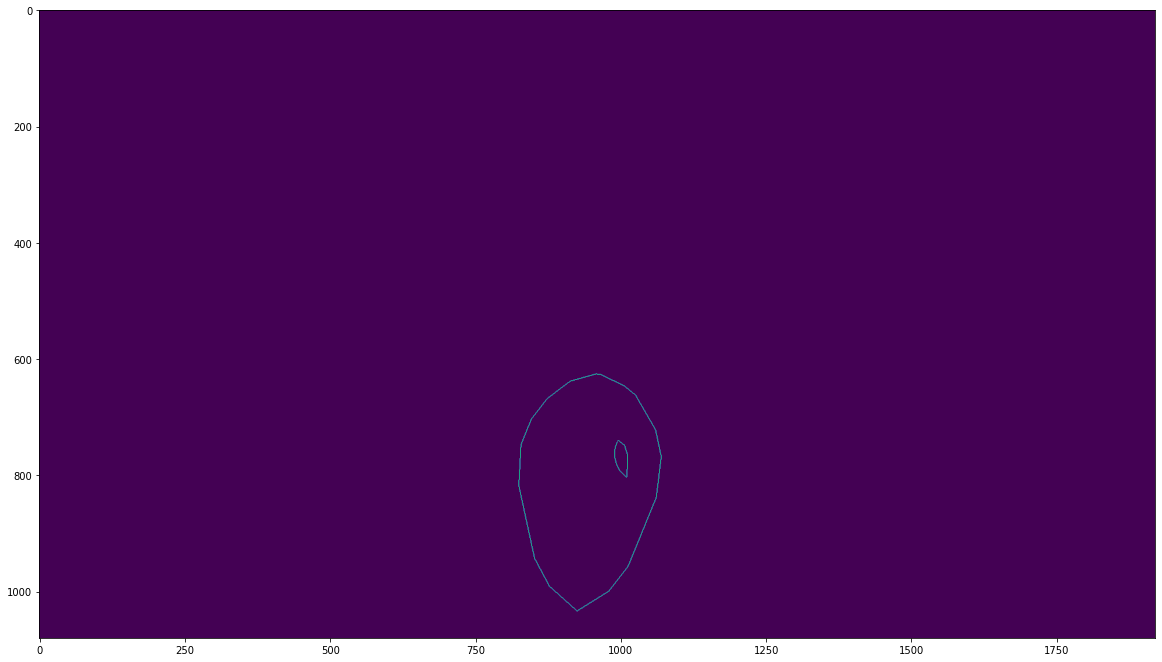

In [18]:
# %matplotlib inline
fig = plt.figure(figsize = (20, 20))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111)
plt.imshow(new_img)

In [19]:
%%time
import joblib
result = joblib.Parallel(n_jobs=-1)(joblib.delayed(pair_and_key_gen)(i, cam_list, cam_pairs_F) for i in cam_pairs_F)

/Users/noshita/working_dir/curve_sketch/src/epipolar.py:126: RuntimeWarning: divide by zero encountered in float_scalars
  return np.array([[0, -c / b] for a, b, c in para_list])
/Users/noshita/working_dir/curve_sketch/src/epipolar.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  return np.array([[img_width, -(img_width * a + c) / b] for a, b, c in para_list])
/Users/noshita/Library/Caches/pypoetry/virtualenvs/curve-sketch-CVtvuAS6-py3.9/lib/python3.9/site-packages/numpy/core/numeric.py:1642: RuntimeWarning: invalid value encountered in multiply
  cp -= a1 * b0
/Users/noshita/working_dir/curve_sketch/src/epipolar.py:159: RuntimeWarning: invalid value encountered in divide
  t1 = np.cross(v, v2) / np.cross(v1, v2)
/Users/noshita/Library/Caches/pypoetry/virtualenvs/curve-sketch-CVtvuAS6-py3.9/lib/python3.9/site-packages/numpy/core/numeric.py:1642: RuntimeWarning: invalid value encountered in subtract
  cp -= a1 * b0


CPU times: user 5.22 s, sys: 578 ms, total: 5.8 s
Wall time: 7.13 s


In [20]:
pair_list = {}
for i in result:
    pair_list.update(i)

In [26]:
#pair_list[key][color][curve][pair]

In [21]:
%%time
result = joblib.Parallel(n_jobs=-1)(joblib.delayed(coll_dict_gen)(i, pair_list, cam_list, cam_pairs_F) for i in pair_list)


/Users/noshita/working_dir/curve_sketch/src/epipolar.py:126: RuntimeWarning: divide by zero encountered in float_scalars
  return np.array([[0, -c / b] for a, b, c in para_list])
/Users/noshita/working_dir/curve_sketch/src/epipolar.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  return np.array([[img_width, -(img_width * a + c) / b] for a, b, c in para_list])
/Users/noshita/working_dir/curve_sketch/src/epipolar.py:244: RuntimeWarning: invalid value encountered in divide
  v1 = v1 / v1_n
/Users/noshita/working_dir/curve_sketch/src/epipolar.py:256: RuntimeWarning: invalid value encountered in divide
  v2 = v2 / v2_n


CPU times: user 51.3 s, sys: 4.7 s, total: 56 s
Wall time: 58.3 s


In [22]:
coll_dict = {}
for i in result:
    coll_dict.update(i)

In [25]:
# 点の一対一対応
pair_pt = {}
for i in coll_dict:
    im_list = []
    for col in coll_dict[i]:
        col_list = []
        for frag in col:
            f_list = []
            for each_frag in frag:
                new_pair = pt_pair(each_frag)
                f_list.append(new_pair)
            col_list.append(f_list)
        im_list.append(col_list)
    pair_pt[i] = im_list

In [34]:
def cv2_circle_array(img, co, size, color, r):
    for i in range(len(co)):
        img = cv2.circle(img, co[i], 10, (0,100,0), -1)
    return img

cnum = 0
new_img = np.zeros((cam_list[0].img.shape[0],cam_list[0].img.shape[1]),dtype=np.bool8)
copy_img = np.copy(cam_list[cnum].img)
for j in range(len(cam_list[cnum].frag_list)):
    for i in range(len(cam_list[cnum].frag_list[j])):
        curve = cam_list[cnum].frag_list[j][i][~np.isnan(cam_list[cnum].frag_list[j][i])].reshape((-1,2)).astype(int)
        if i == 6:
            img = cv2_circle_array(copy_img, curve, 10, (0,0,255), -1)
        #new_img[curve[:,1],curve[:,0]]=True
            break
    break

%matplotlib inline
fig = plt.figure(figsize = (20, 20))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111)
plt.imshow(img)

cnum = 1
new_img = np.zeros((cam_list[0].img.shape[0],cam_list[0].img.shape[1]),dtype=np.bool8)
copy_img = np.copy(cam_list[cnum].img)
for j in range(len(cam_list[cnum].frag_list)):
    for i in range(len(cam_list[cnum].frag_list[j])):
        curve = cam_list[cnum].frag_list[j][i][~np.isnan(cam_list[cnum].frag_list[j][i])].reshape((-1,2)).astype(int)
        if i == 27:
            img = cv2_circle_array(copy_img, curve, 10, (0,0,255), -1)
        #new_img[curve[:,1],curve[:,0]]=True
            break
    break

%matplotlib inline
fig = plt.figure(figsize = (20, 20))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111)

plt.imshow(img)#new_img)

In [31]:
# 座標でdictを作る
coordinate_dict = {}
for i in pair_list:
    pair_coordinate = []
    part, counterpart = FR_frags(i, cam_list=cam_list)
    for part_col, cpart_col, pair_col, PtPair_col in zip(part, counterpart, pair_list[i], pair_pt[i]):
        col_list = []
        for part_frag, pair, pt_idx in zip(part_col, pair_col, PtPair_col):
            for each_pair, each_pt_idx in zip(pair, pt_idx):
                if each_pt_idx[0].size != 0:
                    col_list.append((np.array([part_frag[each_pt_idx[0]], cpart_col[each_pair][each_pt_idx[1]]])))
        pair_coordinate.append(col_list)
    coordinate_dict[i] = pair_coordinate

In [37]:
def connect_points(pts_list):
    sep_list = []
    root = np.transpose(pts_list[0], (1, 0, 2))
    length = len(root)-1
    sep_list.append(length)
    for i, pt in enumerate(pts_list):
        pt = np.transpose(pt, (1, 0, 2))
        if i == 0:
            continue
        root = np.concatenate([root, pt], 0)
        length += len(pt)
        sep_list.append(length)
    return root, sep_list

def sep_array(tri_pts, sep_list):
    # 一つの輪郭に対し削除リストから削除
    start = 0
    newArray = []
    for d in sep_list:
        if tri_pts[start:d].size != 0:
            newArray.append(tri_pts[start:d])
        start = d

    if tri_pts[start:].size != 0:
        newArray.append(tri_pts[start:])
    return newArray

TDlines = []
for i, j in enumerate(coordinate_dict):
    
    pts = coordinate_dict[j]
    P1_ori, P2_ori, F_ori = FR_check(j)
    #pt, sep_list = connect_points(pts)
    temp_TDlines = []
    for pt in pts:
        pt = np.transpose(pt, (1, 0, 2))
        F = np.broadcast_to(F_ori, (pt.shape[0],3,3))
        P1 = np.broadcast_to(P1_ori, (pt.shape[0],3,4))
        P2 = np.broadcast_to(P2_ori, (pt.shape[0],3,4))
        newcoords= np.array(list(map(min_dist, F, pt[:,1,:], pt[:,0,:])))
        tri_pt = np.array(list(map(tri, P1, P2, newcoords[:,1,:], newcoords[:,0,:])))
        #pts_array = sep_array(tri_pt, sep_list)
        temp_TDlines.append(tri_pt)
    TDlines.append(temp_TDlines)
    print((i+1)/len(coordinate_dict)*100)
    break

In [41]:
TDlines = {}
for i, j in enumerate(coordinate_dict):
    
    pts = coordinate_dict[j]
    P1_ori, P2_ori, F_ori = FR_check(j, cam_list=cam_list, cam_pairs_F=cam_pairs_F)
    #pt, sep_list = connect_points(pts)
    temp_TDlines = []
    for pts_col in pts:
        col_list = []
        for pt in pts_col:
            pt = np.transpose(pt, (1, 0, 2))
            F = np.broadcast_to(F_ori, (pt.shape[0],3,3))
            P1 = np.broadcast_to(P1_ori, (pt.shape[0],3,4))
            P2 = np.broadcast_to(P2_ori, (pt.shape[0],3,4))
            newcoords= np.array(list(map(min_dist, F, pt[:,1,:], pt[:,0,:])))
            tri_pt = np.array(list(map(tri, P1, P2, newcoords[:,1,:], newcoords[:,0,:])))
            #pts_array = sep_array(tri_pt, sep_list)
            col_list.append(tri_pt)
        temp_TDlines.append(col_list)
    TDlines[j] = temp_TDlines
    print((i+1)/len(coordinate_dict)*100)


0.3787878787878788
0.7575757575757576
1.1363636363636365
1.5151515151515151
1.893939393939394
2.272727272727273
2.6515151515151514
3.0303030303030303
3.4090909090909087
3.787878787878788
4.166666666666666
4.545454545454546
4.924242424242424
5.303030303030303
5.681818181818182
6.0606060606060606
6.4393939393939394
6.8181818181818175
7.196969696969697
7.575757575757576
7.954545454545454
8.333333333333332
8.712121212121213
9.090909090909092
9.469696969696969
9.848484848484848
10.227272727272728
10.606060606060606
10.984848484848484
11.363636363636363
11.742424242424242
12.121212121212121
12.5
12.878787878787879
13.257575757575758
13.636363636363635
14.015151515151514
14.393939393939394
14.772727272727273
15.151515151515152
15.530303030303031
15.909090909090908
16.28787878787879
16.666666666666664
17.045454545454543
17.424242424242426
17.803030303030305
18.181818181818183
18.560606060606062
18.939393939393938
19.318181818181817
19.696969696969695
20.075757575757574
20.454545454545457
20.83

In [51]:
reprojection_dict = {}
for tag in TDlines:
    temp_reprojection_dict = {}
    P_dict = excluded_Parray(tag[0], cam_list=cam_list)
    for P_tag in P_dict:
        P = P_dict[P_tag]
        P_list = []
        for col in TDlines[tag]:
            col_list = []
            for i, frag in enumerate(col):
                frag = frag.reshape((-1,3))
                frag = np.concatenate([frag, np.ones(len(frag)).reshape((len(frag), 1))],1) # 末尾に1を追加 (X, Y, Z, 1)
                reprojection = dot_P_frag(P, frag)
                col_list.append(reprojection)
            P_list.append(col_list)
        temp_reprojection_dict[P_tag] = P_list
    reprojection_dict[tag] = temp_reprojection_dict

In [53]:
support_dict = gen_support_dict(reprojection_dict, cam_list=cam_list)

/Users/noshita/working_dir/curve_sketch/src/curve_based_reconstruction.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [54]:
sup_th = 10# サポート数
curve_fragment = []
for tag in TDlines:
    #if tag[1] == "R":
    #    continue
    lines_list = TDlines[tag]
    support_list, support_ac = support_dict[tag][0], support_dict[tag][1]
    tag_list = []
    for col, sup_col, ac_col in zip(lines_list, support_list, support_ac):
        col_curve_fragment = []
        for frag, sup, sup_ac in zip(col, sup_col, ac_col):
            if sup > 11:
                frag = np.reshape(frag,(-1, 3))
                frag = np.array([i for i,j in zip(frag, sup_ac >sup_th) if j])
                col_curve_fragment.append(frag)
        tag_list.append(col_curve_fragment)
    curve_fragment.append(tag_list)

In [55]:
cfs = [[],[],[],[],[],[],[],[],[]]
for cols in curve_fragment:
    for i in range(len(cols)):
        if i == 0:
            cfs[0] += cols[i]
        if i == 1:
            cfs[1] += cols[i]
        if i == 2:
            cfs[2] += cols[i]
        if i == 3:
            cfs[3] += cols[i]
        if i == 4:
            cfs[4] += cols[i]
        if i == 5:
            cfs[5] += cols[i]
        if i == 6:
            cfs[6] += cols[i]
        if i == 7:
            cfs[7] += cols[i]
        if i == 8:
            cfs[8] += cols[i]

In [59]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

def plot_graph():
    color_arr = np.array([[255,0,0],[0,255,0],[0,0,255],
                             [255,255,0],[255,0,255],[0,255,255],
                             [127,127,127],[127,0,127],[0,127,127]],dtype = np.int16)
    j = 0
    for i in range(len(cfs)):
        for frag in cfs[i]:
            if frag.size == 0:
                continue
            #print(frag)
            
            
            x = frag[:,0]
            y = frag[:,1]
            z = frag[:,2]
            data = [x,y,z]
            try:
                tck, u= interpolate.splprep(data, k=3)
            except ValueError:
                pass
            except TypeError:
                pass
            new = interpolate.splev(u, tck, der=0)
            c = color_arr[i]/255
            if j % 100 == 0:
                ax.plot(new[0], new[2], new[1],"-",color=c)
            
            j+=1


In [61]:
%matplotlib inline

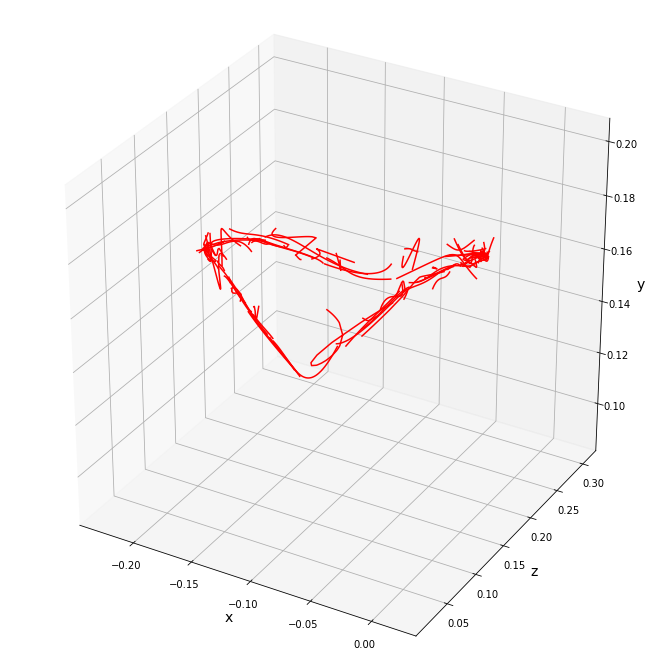

In [62]:
fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
ax.set_box_aspect((1,1,1))
#ax.set_xticks(np.arange(-4,4,1))
#ax.set_yticks(np.arange(-4,4,1))
#ax.set_zticks(np.arange(-2,9,1))

plot_graph()

In [ ]:
import itertools

import open3d as o3d

flatten_curve_frag = np.array(list(itertools.chain.from_iterable(_curve_fragment)))
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(flatten_curve_frag)

o3d.visualization.draw_geometries([pcd])

from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
ax.set_box_aspect((1,1,1))

def plot_graph():
    i = 0
    for c_f in curve_fragment:
        for frag in c_f:
            if frag.size == 0:
                continue
            #print(frag)
            
            if i%100 == 0:
                x = frag[:,0]
                y = frag[:,1]
                z = frag[:,2]
                data = [x,y,z]
                try:
                    tck, u= interpolate.splprep(data, k=3)
                except ValueError:
                    pass
                except TypeError:
                    pass
                new = interpolate.splev(u, tck, der=0)

                ax.plot(new[0], new[2], new[1],"-")
                    #ax.plot(x, z, y,"-")
            i += 1

def plt_graph3d(angle):
    ax.view_init(azim=angle*5)
    
# アニメーションを作成
ani = FuncAnimation(
    fig,
    func=plt_graph3d,
    frames=72,
    init_func=plot_graph,
    interval=200
)

# imagemagickで作成したアニメーションをGIFで書き出す
ani.save("48_rolling.gif", writer="pillow", savefig_kwargs={'transparent': True, 'facecolor': 'none'})
#ani.save('48_anim.mp4', writer="ffmpeg", savefig_kwargs={'transparent': True, 'facecolor': 'none'})

In [49]:
import pickle
with open("one_hole_leaf.curves","wb") as f:
    pickle.dump(curve_fragment, f)